In [1]:
# the basics

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import astropy
from astropy.io import fits
import glob
import os
import h5py # used in the Data Visualization section 
from astropy.coordinates import SkyCoord
import astropy
from astropy.io import fits,ascii,votable
from astropy import units as u 
from astropy import constants as const
from astropy.table import Table
from astropy.cosmology import Planck15 as cosmo

from statistics import mean
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval
from astropy.io import ascii
from astropy.table import Table, SortedArray
import pandas as pd
from astropy.stats import mad_std
from scipy.integrate import quad,simps
from scipy.stats import chisquare
plt.style.use('../cooper-paper.mplstyle')

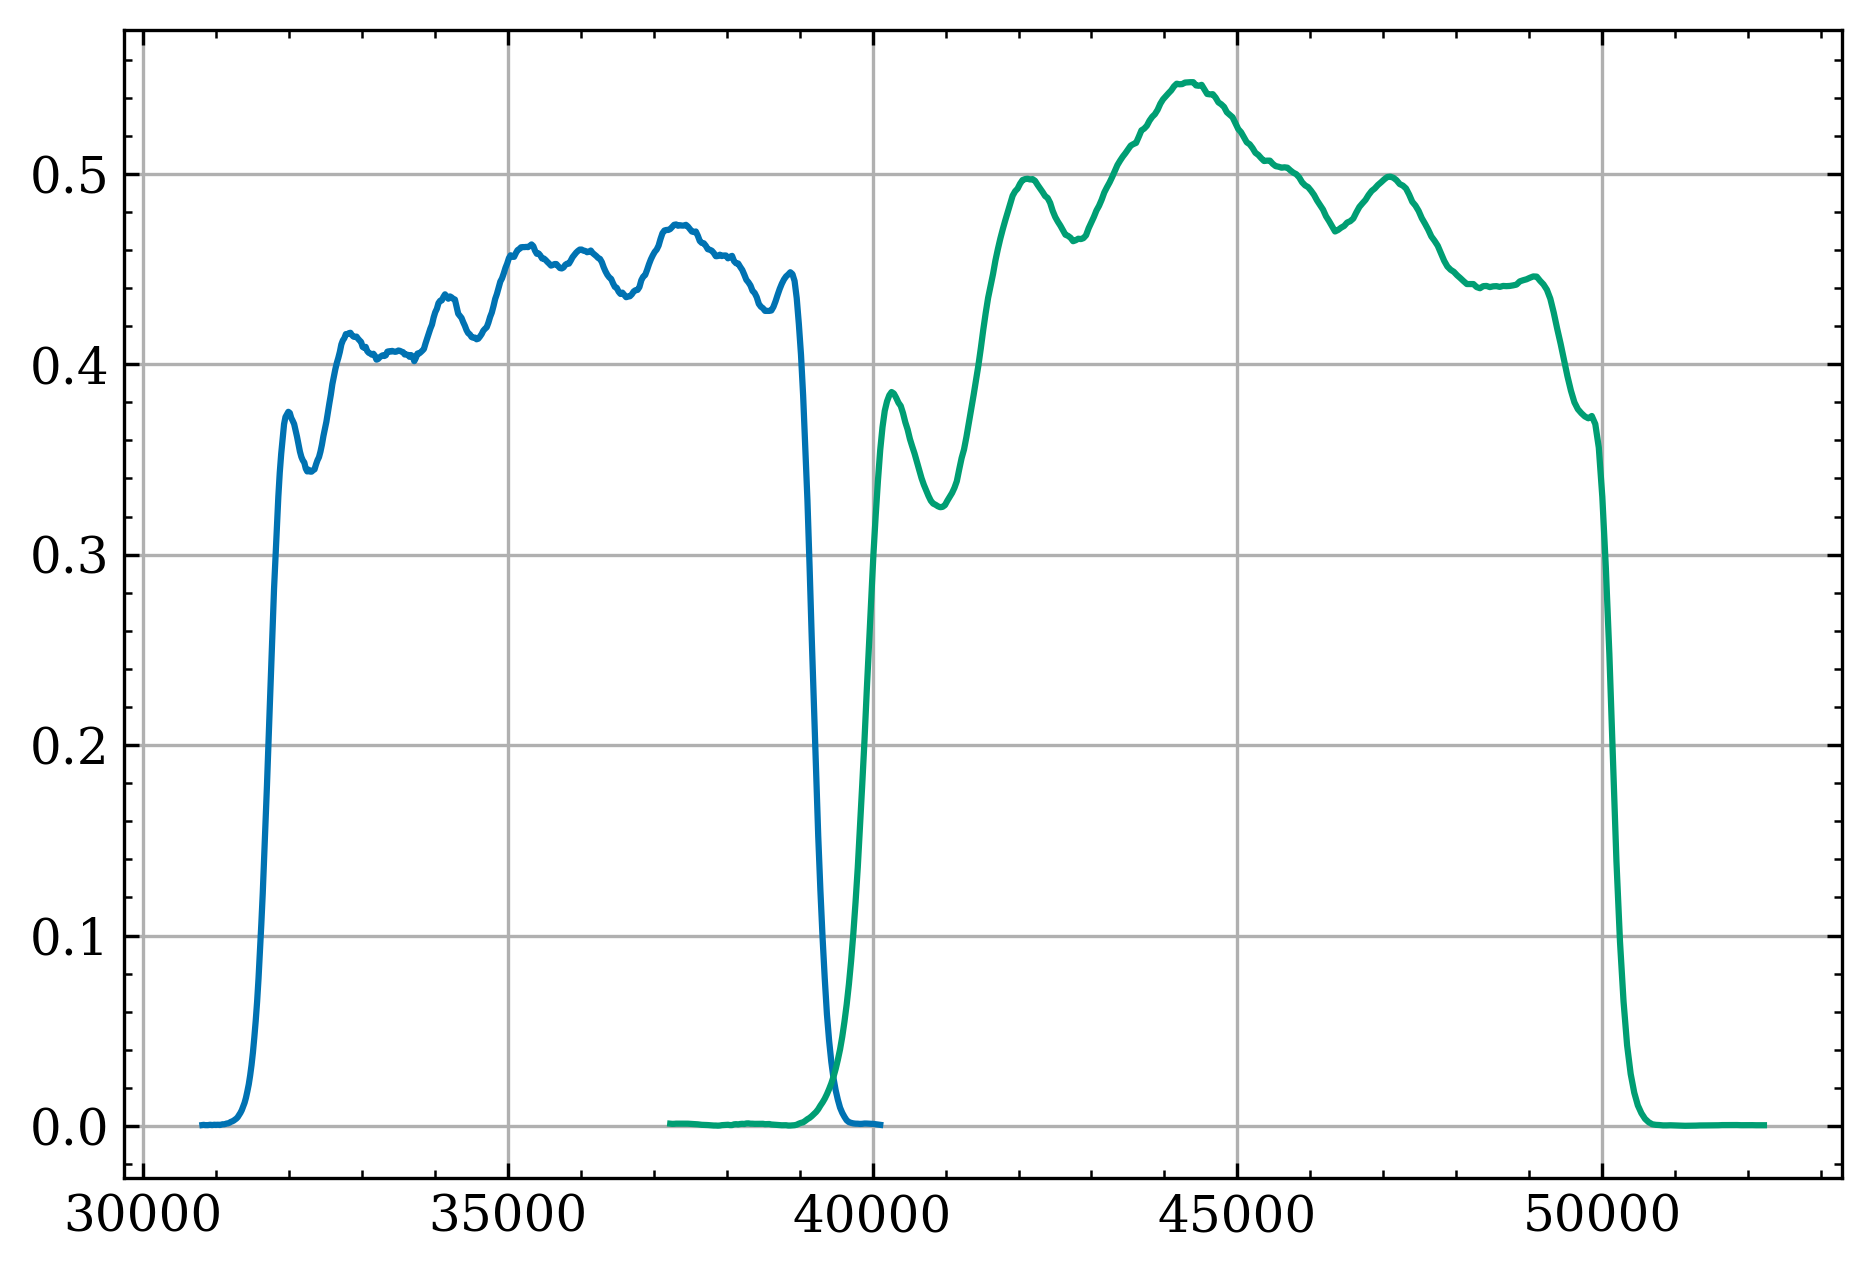

In [2]:
# filter transmission files

ch1_path = 'Spitzer_IRAC.I1.dat'
ch2_path = 'Spitzer_IRAC.I2.dat'

ch1 = Table.read(ch1_path,format='ascii',names=('lambda','t'))
ch2 = Table.read(ch2_path,format='ascii',names=('lambda','t'))
plt.plot(ch1['lambda'],ch1['t'])
plt.plot(ch2['lambda'],ch2['t'])

In [3]:
obj_name = 'B_WP567863'
cat0 = Table.read('WERLSv1_COSMOS2020_FARMER_R1_v2.0.fits',format='fits',hdu=1)
idx = np.where(cat0['obj']==obj_name)[0]
targ = cat0[idx]
targ

mask,slit_no,obj,ID,ypix_mospy,mospy_notes,pypeit_notes,wp,mia,keep,confidence,cquality,zguess,zmeasured,wave,ypix_slit,photoz,photoz_source,MUV,serendip_ra,serendip_dec,pypeit_ref_idx,pypeit_slit,pypeit_name,maskdef_id,objra,objdec,spat_pixpos,spat_fracpos,box_width,opt_fwhm,s2n,maskdef_extract,ALPHA_J2000,DELTA_J2000,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,N_GROUP,FLAG_HSC,FLAG_SUPCAM,FLAG_UDEEP,FLAG_UVISTA,FLAG_COMBINED,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,CFHT_ustar_FLUX,CFHT_ustar_FLUXERR,CFHT_ustar_MAG,CFHT_ustar_MAGERR,CFHT_ustar_CHISQ,CFHT_ustar_DRIFT,CFHT_ustar_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_y_FLUX,HSC_y_FLUXERR,HSC_y_MAG,HSC_y_MAGERR,HSC_y_CHISQ,HSC_y_DRIFT,HSC_y_VALID,UVISTA_Y_FLUX,UVISTA_Y_FLUXERR,UVISTA_Y_MAG,UVISTA_Y_MAGERR,UVISTA_Y_CHISQ,UVISTA_Y_DRIFT,UVISTA_Y_VALID,UVISTA_J_FLUX,UVISTA_J_FLUXERR,UVISTA_J_MAG,UVISTA_J_MAGERR,UVISTA_J_CHISQ,UVISTA_J_DRIFT,UVISTA_J_VALID,UVISTA_H_FLUX,UVISTA_H_FLUXERR,UVISTA_H_MAG,UVISTA_H_MAGERR,UVISTA_H_CHISQ,UVISTA_H_DRIFT,UVISTA_H_VALID,UVISTA_Ks_FLUX,UVISTA_Ks_FLUXERR,UVISTA_Ks_MAG,UVISTA_Ks_MAGERR,UVISTA_Ks_CHISQ,UVISTA_Ks_DRIFT,UVISTA_Ks_VALID,UVISTA_NB118_FLUX,UVISTA_NB118_FLUXERR,UVISTA_NB118_MAG,UVISTA_NB118_MAGERR,UVISTA_NB118_CHISQ,UVISTA_NB118_DRIFT,UVISTA_NB118_VALID,SC_IB427_FLUX,SC_IB427_FLUXERR,SC_IB427_MAG,SC_IB427_MAGERR,SC_IB427_CHISQ,SC_IB427_DRIFT,SC_IB427_VALID,SC_IB464_FLUX,SC_IB464_FLUXERR,SC_IB464_MAG,SC_IB464_MAGERR,SC_IB464_CHISQ,SC_IB464_DRIFT,SC_IB464_VALID,SC_IA484_FLUX,SC_IA484_FLUXERR,SC_IA484_MAG,SC_IA484_MAGERR,SC_IA484_CHISQ,SC_IA484_DRIFT,SC_IA484_VALID,SC_IB505_FLUX,SC_IB505_FLUXERR,SC_IB505_MAG,SC_IB505_MAGERR,SC_IB505_CHISQ,SC_IB505_DRIFT,SC_IB505_VALID,SC_IA527_FLUX,SC_IA527_FLUXERR,SC_IA527_MAG,SC_IA527_MAGERR,SC_IA527_CHISQ,SC_IA527_DRIFT,SC_IA527_VALID,SC_IB574_FLUX,SC_IB574_FLUXERR,SC_IB574_MAG,SC_IB574_MAGERR,SC_IB574_CHISQ,SC_IB574_DRIFT,SC_IB574_VALID,SC_IA624_FLUX,SC_IA624_FLUXERR,SC_IA624_MAG,SC_IA624_MAGERR,SC_IA624_CHISQ,SC_IA624_DRIFT,SC_IA624_VALID,SC_IA679_FLUX,SC_IA679_FLUXERR,SC_IA679_MAG,SC_IA679_MAGERR,SC_IA679_CHISQ,SC_IA679_DRIFT,SC_IA679_VALID,SC_IB709_FLUX,SC_IB709_FLUXERR,SC_IB709_MAG,SC_IB709_MAGERR,SC_IB709_CHISQ,SC_IB709_DRIFT,SC_IB709_VALID,SC_IA738_FLUX,SC_IA738_FLUXERR,SC_IA738_MAG,SC_IA738_MAGERR,SC_IA738_CHISQ,SC_IA738_DRIFT,SC_IA738_VALID,SC_IA767_FLUX,SC_IA767_FLUXERR,SC_IA767_MAG,SC_IA767_MAGERR,SC_IA767_CHISQ,SC_IA767_DRIFT,SC_IA767_VALID,SC_IB827_FLUX,SC_IB827_FLUXERR,SC_IB827_MAG,SC_IB827_MAGERR,SC_IB827_CHISQ,SC_IB827_DRIFT,SC_IB827_VALID,SC_NB711_FLUX,SC_NB711_FLUXERR,SC_NB711_MAG,SC_NB711_MAGERR,SC_NB711_CHISQ,SC_NB711_DRIFT,SC_NB711_VALID,SC_NB816_FLUX,SC_NB816_FLUXERR,SC_NB816_MAG,SC_NB816_MAGERR,SC_NB816_CHISQ,SC_NB816_DRIFT,SC_NB816_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,IRAC_CH3_FLUX,IRAC_CH3_FLUXERR,IRAC_CH3_MAG,IRAC_CH3_MAGERR,IRAC_CH3_CHISQ,IRAC_CH3_DRIFT,IRAC_CH3_VALID,IRAC_CH4_FLUX,IRAC_CH4_FLUXERR,IRAC_CH4_MAG,IRAC_CH4_MAGERR,IRAC_CH4_CHISQ,IRAC_CH4_DRIFT,IRAC_CH4_VALID,VALID_SOURCE,SOLUTION_MODEL,ID_GALEX,GALEX_NUV_FLUX,GALEX_NUV_FLUXERR,GALEX_NUV_MAG,GALEX_NUV_MAGERR,GALEX_FUV_FLUX,GALEX_FUV_FLUXERR,GALEX_FUV_MAG,GALEX_FUV_MAGERR,ID_COSMOS2015,SPLASH_CH1_FLUX,SPLASH_CH1_FLUXERR,SPLASH_CH1_MAG,SPLASH_CH1_MAGERR,SPLASH_CH2_FLUX,SPLASH_CH2_FLUXERR,SPLASH_CH2_MAG,SPLASH_CH2_MAGERR,SPLASH_CH3_FLUX,SPLASH_CH3_FLUXERR,SPLASH_CH3_MAG,SPLASH_CH3_MAGERR,SPLASH_CH4_FLUX,SPLASH_CH4_FLUXERR,SPLASH_CH4_MAG,SPLASH_CH4_MA

In [4]:
flx = '_FLUX'  
flxerr = '_FLUXERR'  # catalog column for flux/mag error, just add 'ERR'
outflx = 'cgs' # 'cgs' or 'uJy'
# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4']  
filt_lambda = [0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796] 
# corresponding MW attenuation from Schelgel 
AlambdaDivEBV = [8.31,8.742,4.807,4.674,3.69,2.715,2.0,1.515,1.298,1.213,0.874,0.565,0.365,4.261,3.844,3.622,3.425,3.265,2.938,2.694,2.431,2.29,2.151,1.997,1.748,2.268,1.787,0.946,4.041,3.738,3.128,2.673,2.003,1.436,1.466,0.163,0.112,0.075,0.045]
# photometric offsets (not available for all filters, see Table 3 in W+21)
zpoff1 = [0.000,-0.352,-0.077,-0.023,0.073,0.101,0.038,0.036,0.086,0.054,0.017,-0.045,0.000,-0.104,-0.044,-0.021,-0.018,-0.045,-0.084,0.005,0.166,-0.023,-0.034,-0.032,-0.069,-0.010,-0.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.212,-0.219,0.000,0.000]  # Farmer+LePhare
zpoff2 = [0.000,-0.029,-0.006,0.053,0.128,0.127,0.094,0.084,0.100,0.049,0.025,-0.044,0.000,-0.013,-0.008,0.022,0.025,0.033,-0.032,0.031,0.208,-0.009,0.003,-0.015,-0.001,0.023,-0.021,-0.017,-0.075,0.000,0.123,0.035,0.051,0.000,0.095,-0.087,-0.111,0.000,0.000]  # Classic+LePhare
zpoff3 = [0.000,0.000,-0.196,-0.054,0.006,0.090,0.043,0.071,0.118,0.078,0.047,-0.034,0.000,-0.199,-0.129,-0.084,-0.073,-0.087,-0.124,0.004,0.154,-0.022,-0.030,-0.013,-0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.102,-0.044,0.000,0.000] # Farmer+EAZY
zpoff4 = [0.000,0.000,0.000,-0.021,0.055,0.124,0.121,0.121,0.145,0.085,0.057,-0.036,0.000,-0.133,-0.098,-0.046,-0.037,-0.038,-0.062,0.038,0.214,0.024,0.022,0.01,0.022,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.021,0.025,0.000,0.000] # Classic+EAZY
# create the dictionary
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4,AlambdaDivEBV[i],[zpoff1[i],zpoff2[i],zpoff3[i],zpoff4[i]]) for i in range(len(filt_name))}
# read in sed template file
hdf = h5py.File("../COSMOS2020_LePhare_v2_20210507_LIB_COMB.hdf5","r")

def dust_ext(w,law=0,ebv=0.):

        law1 = np.loadtxt("../SB_calzetti.dat").T
        law2 = np.loadtxt("../extlaw_0.9.dat").T
        ext_w = [law1[0],law2[0]]
        ext_k = [law1[1],law2[1]]
        if ebv>0.:
            k = np.interp(w,ext_w[law],ext_k[law])
            return np.power(10.,-0.4*ebv*k)
        else:
            return 1.

Text(0.5, 0, 'wavelength [Å]')

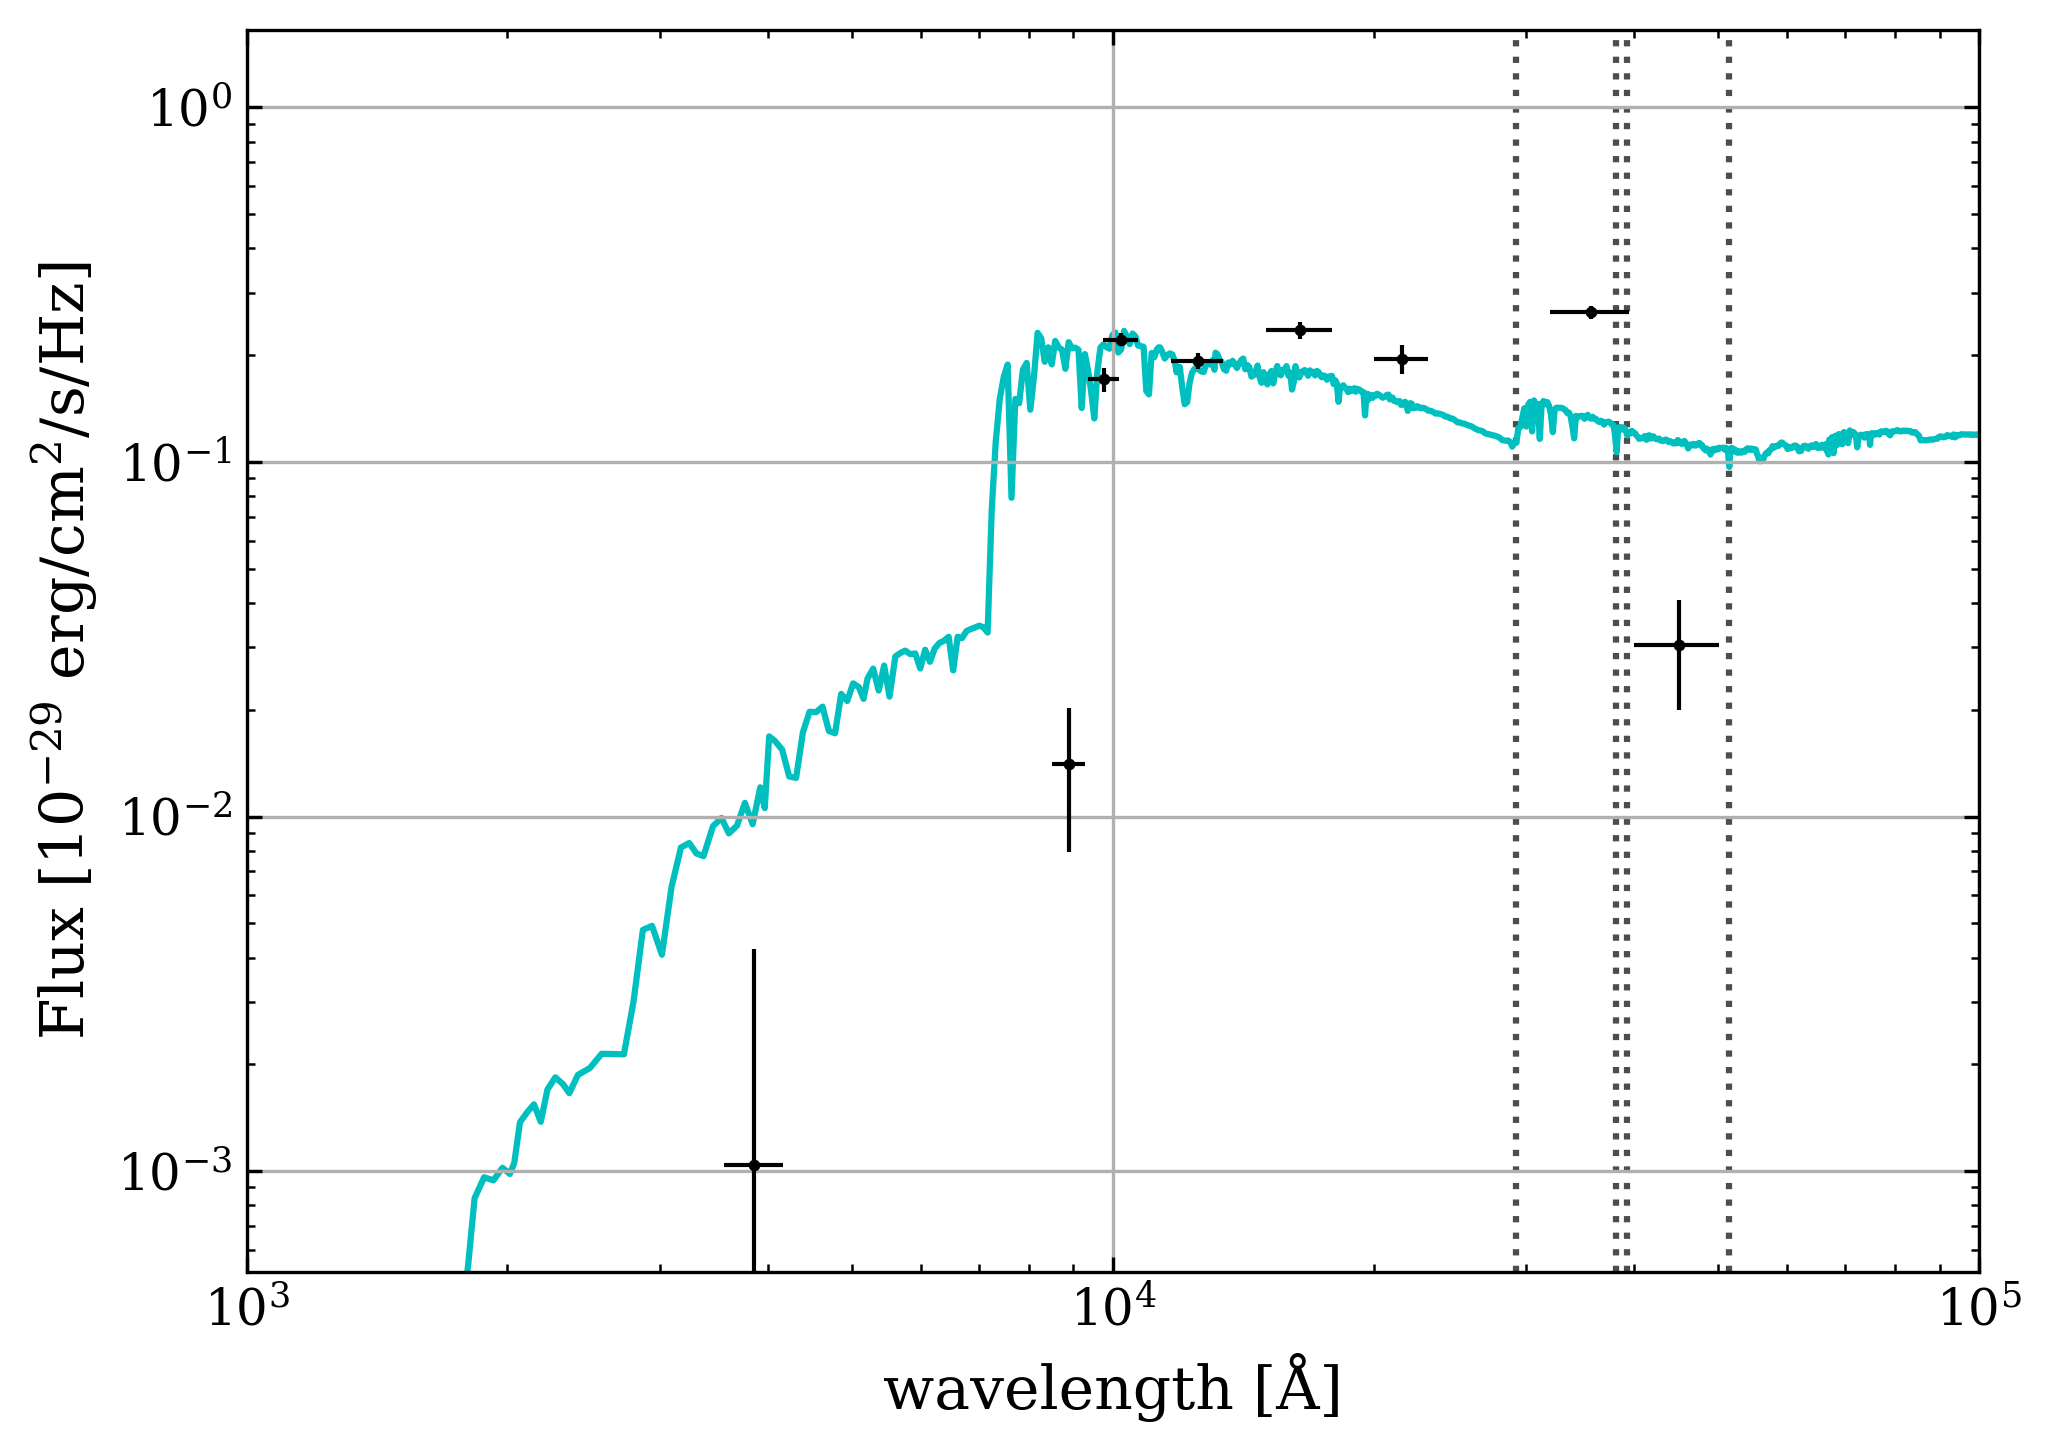

In [5]:
# optional: change the filters you want to use
filt_use = ['CFHT_ustar', 'CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4']


# flux conversion from uJy to erg/cm2/s/Hz
if outflx=='cgs':
    for b in filt_use:
        targ[b+'_FLUX'] *= 1e-29
        targ[b+'_FLUX'].unit = u.erg/u.cm/u.cm/u.s/u.Hz
        targ[b+'_FLUXERR'] *= 1e-29
        targ[b+'_FLUXERR'].unit = u.erg/u.cm/u.cm/u.s/u.Hz
        
# grab just the photometry
photcat = targ[([i+'_FLUX' for i in filt_use]+[i+'_FLUXERR' for i in filt_use])]

wl_obs = np.array([filt_dict[i][0] for i in filt_use]).flatten()  # wavelength center of the filter used 
wl_obserr = (np.array([filt_dict[i][1] for i in filt_use])/2.).flatten()
fnu_obs = np.array([targ[i+'_FLUX'] for i in filt_use]).flatten() # Reads the measured magnitude at that wavelength
fnu_obserr = np.array([targ[i+'_FLUXERR'] for i in filt_use]).flatten() #Magnitude associated +/-error
sel = (fnu_obs>0.).flatten()


### Begin figure!
fig, ax = plt.subplots(1, figsize=[7,5])


if targ['{}_FLUX'.format(filt_use[0])].unit.to_string()=='uJy':
    ax.set_ylabel('Flux [$\mu$Jy]')
    ax.errorbar(wl_obs[sel],fnu_obs[sel],xerr=wl_obserr[sel],yerr=fnu_obserr[sel],fmt='.w', ecolor = 'w', capsize=3, elinewidth=1,zorder=2)
    ymin = min(fnu_obs[sel])*0.5
    ymax = max(fnu_obs[sel]+fnu_obserr[sel])*6
else: # assuming it's cgs
    ax.set_ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')
    ax.errorbar(wl_obs[sel],fnu_obs[sel]*1e29,xerr=wl_obserr[sel],yerr=fnu_obserr[sel]*1e29,fmt='.k', ecolor = 'k', capsize=3, elinewidth=1,zorder=2)
    ax.plot(np.array([3.5686,4.5067]),np.array([photcat['IRAC_CH1_FLUX'],photcat['IRAC_CH2_FLUX']])*1e29,'m')
    ymin = min(fnu_obs[sel])*1e29*0.5
    ymax = max(fnu_obs[sel]+fnu_obserr[sel])*1e29*6
    
# Using the redshift of best-fit template
zp = targ['lp_zBEST']
m = int(targ['lp_model'])
wvl = hdf['/model{}/spectra'.format(m)].attrs['lambda[AA]'] *u.AA 
t = np.abs(hdf['/model{}'.format(m)].attrs['age']-targ['lp_age']).argmin()
flam_mod = hdf['/model{}/spectra'.format(m)][t,:] *u.erg/u.cm/u.cm/u.s/u.AA 
fnu_mod = flam_mod*(wvl**2)/const.c 
# Calculates the flux in units of [uJy] also applying dust ext
fnu_mod = fnu_mod.to(u.erg/u.cm/u.cm/u.s/u.Hz) * dust_ext(wvl.value,law=int(targ['lp_Attenuation']),ebv=targ['lp_dust'])
# Rescale the template
mscal = hdf['/model{}'.format(m)].attrs['mass'][t]/10**targ['lp_mass_best']  # luminosity/mass resc
dm = cosmo.luminosity_distance(zp)/(10*u.pc)  # distance modulus
offset = dm.decompose()**2*mscal/(1+zp) # all together * (1+z) factor


# Plot the best-fit model 
ax.plot(wvl*(1+zp),fnu_mod.to(u.uJy).value/offset,color='c',alpha=1,label='model',zorder=1) 

# Show where nebular emission lines would potentially boost the flux
ax.vlines(3727*(1+zp),ymin,ymax,label='[OII]',zorder=0,color='0.3',ls=':')
ax.vlines(5007*(1+zp),ymin,ymax,label='[OIII]b',zorder=0,color='0.3',ls=':')
ax.vlines(4861*(1+zp),ymin,ymax,label='Hb',zorder=0,color='0.3',ls=':') # H_beta
ax.vlines(6563*(1+zp),ymin,ymax,label='Ha',zorder=0,color='0.3',ls=':') # H_alpha 

# set plot limits
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1000,100000) 
ax.set_ylim(ymin,ymax)
ax.set_xlabel('wavelength [Å]')


In [10]:
def maginfilt(filt,flux,wav):
    
    c = 3e18 # in Angstrom/s
    freq = (1 / wav) * c # all in Hz
    f_lam = fnu * (freq**2/c)
    
    t = np.interp(wav,filt['lambda'],filt['t'])

    num = (1/freq)*f_lam*t
    denom = (1/freq)*t
    integ_num = simps(num, freq)
    integ_denom = simps(denom, freq)
    f_filt = integ_num / integ_denom
    
    jy = f_filt/1e-23
    mag = -2.5*(np.log10(jy/3631))
    
    return mag

In [11]:
wave = (wvl*(1+zp)).value
fnu = fnu_mod.to(u.Jy).value/offset.value

In [12]:
# [3.6] - [4.5]

ch1 = maginfilt(ch1,fnu,wave)
ch2 = maginfilt(ch2,fnu,wave)

color = ch1 - ch2
print(color)

-0.3620882711704283


In [13]:
ch1,ch2

(-54.93255405758674, -54.570465786416314)

In [15]:
photcat['IRAC_CH1_FLUX'].to(u.ABmag) - photcat['IRAC_CH2_FLUX'].to(u.ABmag)

<Magnitude [-2.34708896] mag>

In [16]:
photcat['IRAC_CH1_FLUX'], photcat['IRAC_CH2_FLUX']

(<MaskedColumn name='IRAC_CH1_FLUX' dtype='float64' unit='erg / (cm2 Hz s)' length=1>
 2.6450048356769038e-30,
 <MaskedColumn name='IRAC_CH2_FLUX' dtype='float64' unit='erg / (cm2 Hz s)' length=1>
 3.04502516132391e-31)